# Gov Exploratory Analysis - 3nd step

### Etapa de análise exploratória dos dados;

### Author: Marcos Vinicius Ribeiro Silva

## Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import numpy as np

from sklearn.preprocessing import normalize
from pylab import rcParams
%matplotlib inline

sns.set_theme(style="darkgrid")

## Load dataset

In [2]:
if 'new_data.csv' not in os.listdir(os.getcwd()):
    raise Exception('Run 1st step script!')

df = pd.read_csv('new_data.csv')
df.sample(10)

,CODUFMUN,TP_UNID,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ESTADO,REGIAO,CODUF,CODMUN
1927420,251080,5,29,29,0,11,18,PB,NE,25,2510808
1572820,431590,5,6,4,2,6,22,RS,SU,43,4315909
47710,261330,5,5,5,0,11,18,PE,NE,26,2613305
17343,210150,5,8,8,0,6,19,MA,NE,21,2101509
2363001,430330,5,4,2,2,5,19,RS,SU,43,4303301
458585,350010,5,1,1,0,8,20,SP,SE,35,3500105
1945932,130260,7,5,5,0,2,20,AM,NO,13,1302603
2305611,355030,5,16,16,0,7,18,SP,SE,35,3550308
1560423,522170,5,1,1,0,2,22,GO,CO,52,5221700
2452119,250750,7,12,12,0,3,18,PB,NE,25,2507507


## Create feature to time series

In [3]:
df = df.sort_values(by=["ANO", "MES"])

df["ANO_S"] = [str(x).zfill(2) for x in df['ANO']]
df["MES_S"] = [str(x).zfill(2) for x in df['MES']]
df["ANO-MES"] = df['ANO_S'] + "-" + df["MES_S"]
df = df.drop(["ANO_S", "MES_S"], axis=1)
df.head()

,CODUFMUN,TP_UNID,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ESTADO,REGIAO,CODUF,CODMUN,ANO-MES
115892,290010,5,3,3,0,1,17,BA,NE,29,2900108,17-01
115893,290010,5,1,1,0,1,17,BA,NE,29,2900108,17-01
115894,290010,5,4,4,0,1,17,BA,NE,29,2900108,17-01
115895,290010,5,2,2,0,1,17,BA,NE,29,2900108,17-01
115896,290020,5,8,8,0,1,17,BA,NE,29,2900207,17-01


## Analysis

### Número de leitos no estado de Goiás

In [4]:
df_GO = df[df.ESTADO == 'GO']
df_GO = df_GO.drop(['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO', 'ESTADO'], axis=1)
df_GO.sample(10)

,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ANO-MES
1830248,1,1,0,7,19,19-07
469896,8,8,0,8,18,18-08
3100650,1,1,0,5,21,21-05
2923428,4,3,1,4,18,18-04
3417446,7,7,0,2,18,18-02
3346015,2,2,0,12,21,21-12
2019531,10,10,0,12,19,19-12
2123342,3,3,0,6,20,20-06
2080600,10,3,7,10,22,22-10
1807988,30,20,10,8,17,17-08


In [5]:
df_GO_year = df_GO.groupby('ANO').sum()

qt_exist_ant, qt_sus_ant, qt_nsus_ant = 0, 0, 0
qt_exist_dif, qt_sus_dif, qt_nsus_dif = [], [], []

for i in range(df_GO_year.shape[0]):
    row = df_GO_year.iloc[i]
    if qt_exist_ant > 0:
        qt_exist_dif.append((row.QT_EXIST - qt_exist_ant) / row.QT_EXIST * 100)
    else:
        qt_exist_dif.append(0)
    
    if qt_sus_ant > 0:
        qt_sus_dif.append((row.QT_SUS - qt_sus_ant) / row.QT_SUS * 100)
    else:
        qt_sus_dif.append(0)
        
    if qt_nsus_ant > 0:
        qt_nsus_dif.append((row.QT_NSUS - qt_nsus_ant) / row.QT_NSUS * 100)
    else:
        qt_nsus_dif.append(0)
        
    qt_sus_ant = row.QT_SUS
    qt_exist_ant = row.QT_EXIST
    qt_nsus_ant = row.QT_NSUS

df_GO_year = pd.DataFrame({'QT_EXIST': df_GO_year.QT_EXIST,
                           'QT_EXIST_%': qt_exist_dif,
                           'QT_SUS': df_GO_year.QT_SUS,
                           'QT_SUS_%': qt_sus_dif,
                           'QT_NSUS': df_GO_year.QT_NSUS,
                           'QT_NSUS_%': qt_nsus_dif})

df_GO_year.head()

,QT_EXIST,QT_EXIST_%,QT_SUS,QT_SUS_%,QT_NSUS,QT_NSUS_%
ANO,,,,,,
17,234694,0.000000,141975,0.000000,92719,0.000000
18,213896,-9.723417,128587,-10.411628,85309,-8.686071
19,228619,6.439972,138217,6.967305,90402,5.633725
20,244056,6.325188,147242,6.129365,96814,6.623009
21,268178,8.994772,161935,9.073394,106243,8.874938


### Conclusão

Em valores absolutos podemos observar o numero de leitos antes da pandemia apresentava regressão no número de leitos. Nos anos da pandemia (de 2019 a 2021) o estado manteve uma alta constante de 6% ao ano no número de leitos geral e também no numero de leitos no SUS.

         QT_EXIST  QT_SUS  QT_NSUS
ANO-MES                           
17-01       19490   12122     7368
17-02       19540   12147     7393
17-03       19593   11939     7654
17-04       19636   11865     7771
17-05       19570   11820     7750


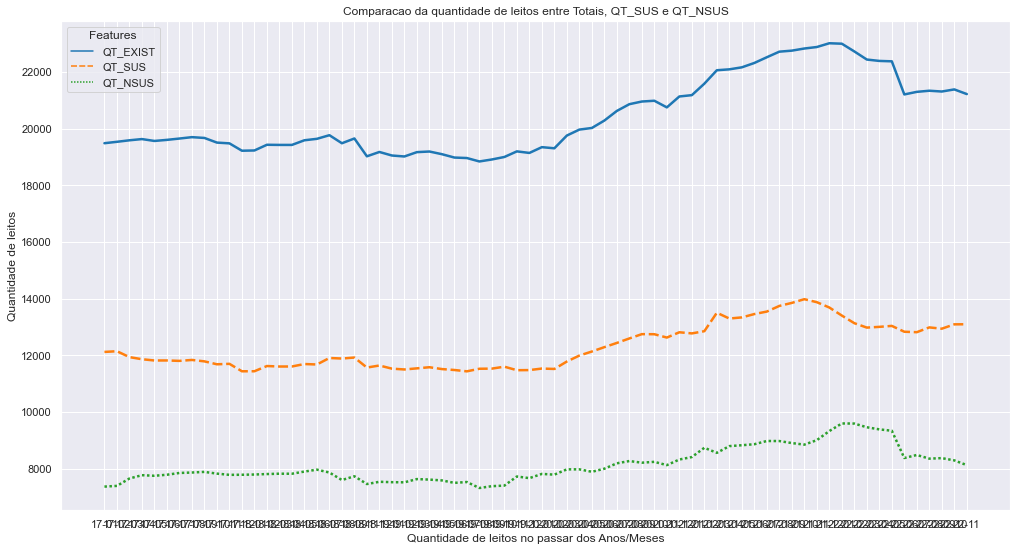

In [6]:
rcParams['figure.figsize'] = 17, 9
df_GO_graph = df_GO.drop(['ANO', 'MES'], axis=1)
df_GO_graph = df_GO_graph.groupby('ANO-MES').sum()
print(df_GO_graph.head())

x = sns.lineplot(data=df_GO_graph, palette="tab10", linewidth=2.5)
x.set_ylabel('Quantidade de leitos')
x.set_xlabel('Quantidade de leitos no passar dos Anos/Meses')
x.set_title('Comparacao da quantidade de leitos entre Totais, QT_SUS e QT_NSUS')
x.legend(title='Features')

### Conclusão:
No gráfico acima podemos ver o números de leitos (em valores absolutos) disponíveis no estado de Goiás do começo do ano de 2017 ao final do ano de 2021. Fica claro a curva ascendente no número de leitos disponíveis no estado no período da pandemia. Ainda podemos abservar que mesmo ao final do período da pandemia (final de 2020) o número de leitos vem diminuindo mas ainda permanece muito acima do período antes da pandemia.

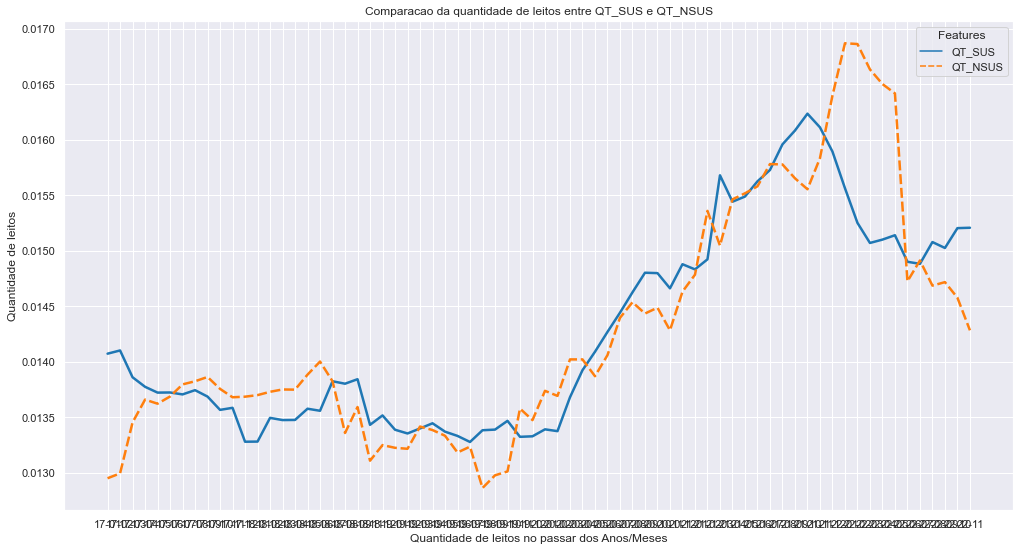

In [7]:
rcParams['figure.figsize'] = 17, 9
df_GO_graph = df_GO.drop(['ANO', 'MES', 'QT_EXIST'], axis=1)

# normalize
for column in ['QT_SUS', 'QT_NSUS']:
    x = df_GO_graph[column].values
    x_scaled = normalize([x], norm="l1")
    df_GO_graph[column] = x_scaled[0]

df_GO_graph = df_GO_graph.groupby('ANO-MES').sum()
x = sns.lineplot(data=df_GO_graph, palette="tab10", linewidth=2.5)
x.set_ylabel('Quantidade de leitos')
x.set_xlabel('Quantidade de leitos no passar dos Anos/Meses')
x.set_title('Comparacao da quantidade de leitos entre QT_SUS e QT_NSUS')
x.legend(title='Features')

### Conclusão
No gráfico acima podemos comparar o número de leitos (em valores normalizados) disponibilizados pelo SUS em comparação aos leitos disponiblizados pelas outras redes hospitalares do estado. Podemos concluir com este gráfico que o SUS teve um desempenho compatível com as redes de leitos privadas e conveniadas do estado de Goiás no quesito disponibilização de leitos no período da pandemia.

### Número de leitos no estado de Goiás comparados com o Centro-Oeste

In [8]:
df_CO = df[df.REGIAO == 'CO']
df_CO = df_CO.drop(['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO'], axis=1)
df_CO.sample(10)

,QT_EXIST,QT_SUS,QT_NSUS,MES,ANO,ESTADO,ANO-MES
2385579,2,2,0,9,18,MT,18-09
1829865,20,20,0,7,19,GO,19-07
3484471,8,8,0,4,17,MT,17-04
2220880,5,0,5,7,20,MS,20-07
3246647,5,5,0,10,21,GO,21-10
319130,2,2,0,8,21,GO,21-08
228481,3,3,0,5,19,MT,19-05
3363243,5,5,0,11,17,MT,17-11
2290418,4,4,0,11,22,GO,22-11
1334221,7,4,3,5,17,GO,17-05


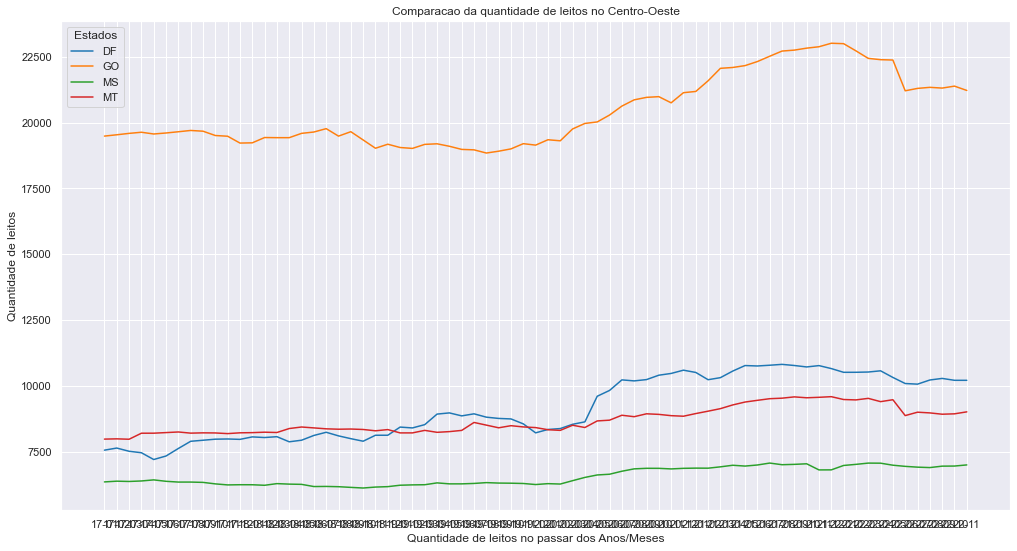

In [9]:
rcParams['figure.figsize'] = 17, 9
df_CO = df[df.REGIAO == 'CO']


list_drop = ['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO', 
             'ANO', 'MES', 'QT_SUS', 'QT_NSUS']

df_CO = df_CO.drop(list_drop, axis=1)
df_CO = df_CO.groupby(by=['ANO-MES', 'ESTADO'], as_index=False).sum()

x = sns.lineplot(data=df_CO, x='ANO-MES', y='QT_EXIST', hue='ESTADO', palette="tab10")
x.set_ylabel('Quantidade de leitos')
x.set_xlabel('Quantidade de leitos no passar dos Anos/Meses')
x.set_title('Comparacao da quantidade de leitos no Centro-Oeste')
x.legend(title='Estados')

## Conclusão:

Neste gráfico podemos observar a quantidade de leitos no estado de Goiás em comparação aos outros estados do Centro-Oeste. Mesmo tendo área quadrada próxima aos outros estados podemos ver que estado de Goiás tem muito mais leitos disponíveis na região e que ainda, podemos percerber que a curva de disponibilização de leitos na região é mais progressiva e mais consistente que os outros estados.

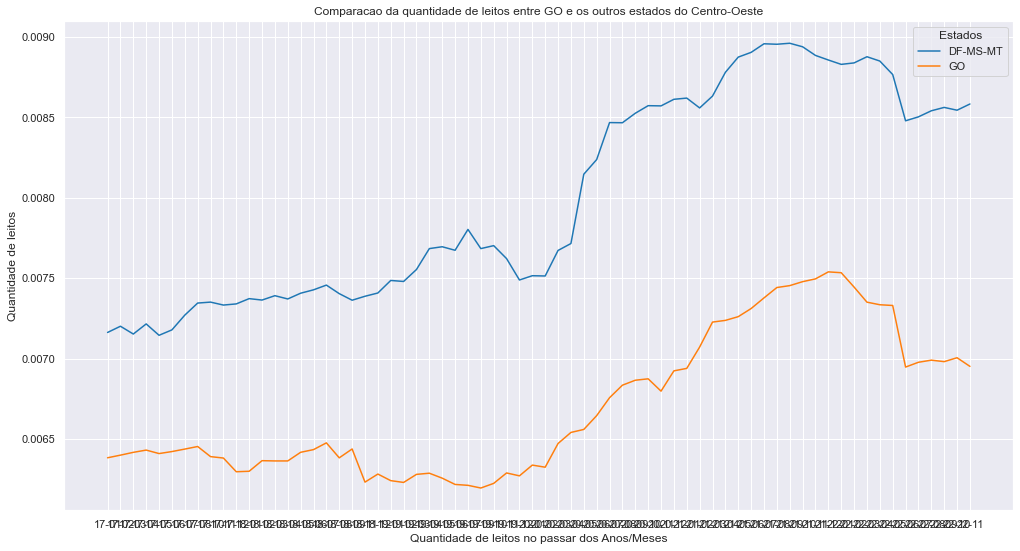

In [10]:
rcParams['figure.figsize'] = 17, 9
df_CO = df[df.REGIAO == 'CO']

# Drop features we wont use for compare
list_drop = ['CODUFMUN', 'TP_UNID', 'CODUF', 'CODMUN', 'REGIAO', 
             'ANO', 'MES', 'QT_SUS', 'QT_NSUS']
df_CO = df_CO.drop(list_drop, axis=1)

# Group and sum values by year, month and state;
df_CO = df_CO.groupby(by=['ANO-MES', 'ESTADO'], as_index=False).sum()

# Remove rows where don't existe values for all states;
list_dates = list(set(df_CO['ANO-MES']))
null_values = []
for date in list_dates:
    if df_CO[df_CO['ANO-MES'] == date].shape[0] < 4:
        null_values.append(date)

df_CO = df_CO.loc[df_CO.apply(lambda x: x['ANO-MES'] not in null_values, axis=1)]

# Separete another states of midwest without GO and sum values
df_AUX = df_CO[df_CO.ESTADO != 'GO']
df_AUX = df_AUX.groupby(by=['ANO-MES'], as_index=False).sum()
df_AUX['ESTADO'] = 'DF-MS-MT'


# Join in the same dataset sum of another states and GO
df_CO = df_CO[df_CO.ESTADO == 'GO']
df_CO = df_CO.append(df_AUX, ignore_index=True)
df_CO = df_CO.sort_values(by=["ANO-MES", 'ESTADO'])

# Normalise dataset
for column in ['QT_EXIST']:
    x = df_CO[column].values
    x_scaled = normalize([x], norm="l1")
    df_CO[column] = x_scaled[0]
    
# Plot lineplot of dataset
x = sns.lineplot(data=df_CO, x='ANO-MES', y='QT_EXIST', hue='ESTADO', palette="tab10")
x.set_ylabel('Quantidade de leitos')
x.set_xlabel('Quantidade de leitos no passar dos Anos/Meses')
x.set_title('Comparacao da quantidade de leitos entre GO e os outros estados do Centro-Oeste')
x.legend(title='Estados')

## Conclusão

Comparando o estado de Goiás com a soma dos outros estados do Centro-Oeste temos que a ordem de crescimento de disponibilização de leitos no estado é na mesma ordem de grandeza que todos os outros estados do Centro-Oeste somados.

  MUNI_REGION ANO-MES  QT_EXIST
0               17-01        14
1               17-02        14
2               17-03        14
3               17-04        14
4               17-05        14


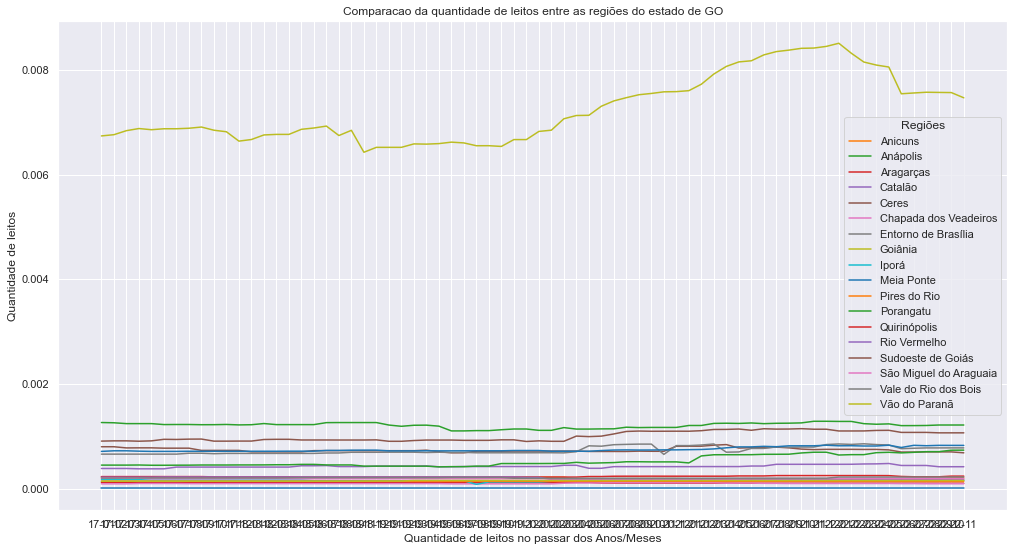

In [12]:
rcParams['figure.figsize'] = 17, 9
df_CO = df[df['ESTADO'] == 'GO']

# remove features that will not be compared
drop_features = ['CODUFMUN', 'TP_UNID', 'ESTADO', 'REGIAO', 'CODUF',
                 'QT_SUS', 'QT_NSUS', 'MES', 'ANO']
df_CO = df_CO.drop(drop_features, axis=1)

# get name of city with ibge API
list_cities = list(set(df_CO['CODMUN']))

link_api = 'https://servicodados.ibge.gov.br/api/v1/localidades/municipios/{}'
cities_name, cities_macroregion = {}, {}
for city in list_cities:
    link_get = link_api.format(city)
    req = requests.get(link_get)
    req.enconding = 'utf-8'
    file = json.loads(req.text)
    
    if len(file) > 0:
        cities_name.update({city: file['nome']})
        cities_macroregion.update({city: file['microrregiao']['nome']})

# Update name of region and set your micro-region
df_CO['MUNI_NOME'] = ''
df_CO['MUNI_REGION'] = ''

for index, row in df_CO.iterrows():
    if row['CODMUN'] in cities_name:
        df_CO.at[index, 'MUNI_NOME'] = cities_name[row['CODMUN']]
    if row['CODMUN'] in cities_macroregion:
        df_CO.at[index, 'MUNI_REGION'] = cities_macroregion[row['CODMUN']]

# group dataset for region
df_CO = df_CO.drop(['CODMUN', 'MUNI_NOME'], axis=1)
df_CO = df_CO.groupby(by=['MUNI_REGION', 'ANO-MES'], as_index=False).sum()
print(df_CO.head())

# Normalise dataset
for column in ['QT_EXIST']:
    x = df_CO[column].values
    x_scaled = normalize([x], norm="l1")
    df_CO[column] = x_scaled[0]

x = sns.lineplot(data=df_CO, x='ANO-MES', y='QT_EXIST', hue='MUNI_REGION', palette="tab10")
x.set_ylabel('Quantidade de leitos')
x.set_xlabel('Quantidade de leitos no passar dos Anos/Meses')
x.set_title('Comparacao da quantidade de leitos entre as regiões do estado de GO')
x.legend(title='Regiões')

## Conclusão

Analisando somente o estado de GO, podemos concluir que a região em torno da capital do estado tem uma ampliação significantemente maior que as outras regiões, tal qual, não torna visível nesta escala (mesmo que normalizado) uma comparação justa entre estas outras regiões.

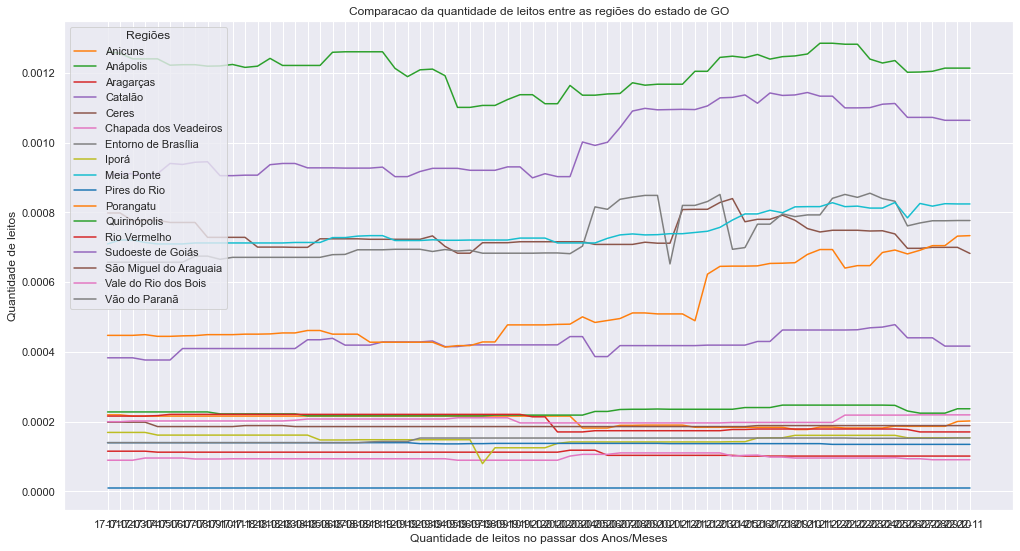

In [13]:
# remove capital region of dataset
df_CO = df_CO[df_CO['MUNI_REGION'] != 'Goiânia']

x = sns.lineplot(data=df_CO, x='ANO-MES', y='QT_EXIST', hue='MUNI_REGION', palette="tab10")
x.set_ylabel('Quantidade de leitos')
x.set_xlabel('Quantidade de leitos no passar dos Anos/Meses')
x.set_title('Comparacao da quantidade de leitos entre as regiões do estado de GO')
x.legend(title='Regiões')

## Conclusão

Comparando as regiões sem a região da capital, podemos reparar que as regiões que já possuiam um número maior de leitos, no período da pandemia também eleva sua quantidade de leitos, mas não de forma tão efetiva e clara quanto a região da capital do estado.

# Final conclusions

As conclusões finais demonstram que o objetivo deste projeto de afirmar a reportagem do governo de Goiás se mantém veridica.

Nesta análise exploratória podemos concluir que o número de leitos no estado de Goiás apresenta abrupto aumento no seu número no período da pandemia e uma queda em seguinte. Porém, mesmo com a queda em seguinte ao momento da pandemia, o número e leitos se mantém superior ao período antes da pandemia no estado.

## Author: Marcos Vinicius Ribeiro Silva